In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append("/Users/sebastian/University/Bachelor/Thesis/ba-thesis/")
from utils import load_files, get_rdms, get_rdm, get_spearmanr, inter_intra_similarity
%load_ext autoreload
%autoreload 2

In [2]:
def load_tensors(directory):
    d = {}
    for key in os.listdir(directory):
        if key.endswith(".pt"):
            filename = os.path.join(directory, key)
            tensor = torch.load(filename)
            d[key[:-3]] = tensor
    return d

In [17]:
avg_visual = load_tensors("avg_visual_lhrh/")
clip_txt = load_tensors("clip_txt_rdms/")
gpt = load_tensors("gpt_rdms/")
albef_txt = load_tensors("albef3_txt_rdms/")
albef_multi = load_tensors("albef3_multi_rdms/")
bert = load_tensors("bert_txt_rdms/")
avg_words = load_tensors("avg_words_lhrh")

In [27]:
albef_txt1 = load_tensors("albef_txt_rdms/")
albef_txt2 = load_tensors("albef3_txt_rdms/")


In [30]:
albef_txt1['ALBEF Text Layer 1'] == albef_txt2['ALBEF Text Layer 1']

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [5]:
avg_faces = load_tensors("avg_faces_lhrh")
avg_places = load_tensors("avg_places_lhrh")
avg_streams = load_tensors("avg_streams_lhrh")
avg_body = load_tensors("avg_body_lhrh")

In [6]:
avg_bonner = load_tensors("avg/")
sclip_txt = load_tensors("sclip_txt_rdms/")
salbef_txt = load_tensors("salbef_txt_rdms/")
salbef_multi = load_tensors("salbef_multi_rdms/")
sgpt = load_tensors("sgpt_rdms/")
sbert = load_tensors("sbert_txt_rdms/")

In [18]:
words_comp = avg_words | bert  | gpt | albef_txt | clip_txt | albef_multi
faces_comp = avg_faces | bert  | gpt | albef_txt | clip_txt | albef_multi
places_comp = avg_places | bert  | gpt | albef_txt | clip_txt | albef_multi
body_comp = avg_body | bert | gpt | albef_txt | clip_txt | albef_multi
streams_comp = avg_streams | bert | gpt | albef_txt | clip_txt | albef_multi
visual_comp = avg_visual | bert | gpt | albef_txt | clip_txt | albef_multi
bonner_comp = avg_bonner | sbert | sgpt | salbef_txt | sclip_txt | salbef_multi
_, all_res_bonner = get_spearmanr(bonner_comp, 81)
_, all_res_faces = get_spearmanr(faces_comp, 872)
_, all_res_body = get_spearmanr(body_comp, 872)
_, all_res_streams = get_spearmanr(streams_comp, 872)
_, all_res_visual = get_spearmanr(visual_comp, 872)
_, all_res_places = get_spearmanr(places_comp, 872)
_, all_res_words = get_spearmanr(words_comp, 872)

100%|█████████████████████████████████████████████| 52/52 [03:34<00:00,  4.12s/it]


In [19]:
def filter_results(res, avg):
    filtered = {key: res[key] for key in list(avg.keys()) if key in res}
    return filtered

In [20]:
f_words = filter_results(all_res_words, avg_words)
f_faces = filter_results(all_res_faces, avg_faces)
f_places = filter_results(all_res_places, avg_places)
f_body = filter_results(all_res_body, avg_body)
f_streams = filter_results(all_res_streams, avg_streams)
f_visual = filter_results(all_res_visual, avg_visual)
f_bonner = filter_results(all_res_bonner, avg_bonner)

In [21]:
all_filtered = {}
all_filtered['Faces'] = f_faces
all_filtered['Places'] = f_places
all_filtered['Body'] = f_body
all_filtered['Streams'] = f_streams
all_filtered['Visual'] = f_visual
all_filtered['Words'] = f_words
all_filtered['Bonner'] = f_bonner

In [22]:
d_total = {}
for k1, v1 in all_filtered.items():
    d_inner = {}
    for k2, v2 in all_filtered[k1].items():
        d_res = {}
        d_res['Albef Text'] = []
        d_res['Albef Multi'] = []
        d_res['Gpt'] = []
        d_res['Bert'] = []
        d_res['Clip'] = []
        for k, v in all_filtered[k1][k2].items():
            if "Bert" in k:
                d_res['Bert'].append((k,v))
            elif "GPT" in k:
                d_res['Gpt'].append((k,v))
            elif "CLIP" in k:
                d_res['Clip'].append((k,v))
            elif "ALBEF Text" in k:
                d_res['Albef Text'].append((k,v))
            elif "ALBEF Multi" in k:
                d_res['Albef Multi'].append((k,v))
            else:
                continue
        d_inner[k2] = d_res
    d_total[k1] = d_inner

In [23]:
# What Im doing here is selecting for every ROI (e.g. FFA-1_lh) 
# the best layer with the highest correlation for every model
for broad_roi in d_total.keys():
    for spec_roi in d_total[broad_roi].keys():
        for model in d_total[broad_roi][spec_roi].keys():
            all_vals = d_total[broad_roi][spec_roi][model]
            tuple_with_highest_value = max(all_vals, key=lambda x: x[1])
            d_total[broad_roi][spec_roi][model] = tuple_with_highest_value

In [24]:
permutation_dict = {}
for top_key, lower_keys in d_total.items():
    for lower_key in lower_keys:
        permutation_dict[lower_key] = d_total[top_key][lower_key]

In [25]:
# Now I am combining all the best models for each ROI up to it's broader ROI level (eg FFA-1 -> Faces)
for broad_roi in d_total.keys():
    d_res = {}
    d_res['Albef Text'] = []
    d_res['Albef Multi'] = []
    d_res['Gpt'] = []
    d_res['Bert'] = []
    d_res['Clip'] = []
    for spec_roi in d_total[broad_roi].keys():
        for model in d_total[broad_roi][spec_roi].keys():
            if "Bert" in model:
                d_res['Bert'].append((d_total[broad_roi][spec_roi][model], spec_roi))
            elif "Gpt" in model:
                d_res['Gpt'].append((d_total[broad_roi][spec_roi][model], spec_roi))
            elif "Clip" in model:
                d_res['Clip'].append((d_total[broad_roi][spec_roi][model], spec_roi))
            elif "Albef Text" in model:
                d_res['Albef Text'].append((d_total[broad_roi][spec_roi][model], spec_roi))
            elif "Albef Multi" in model:
                d_res['Albef Multi'].append((d_total[broad_roi][spec_roi][model], spec_roi))
    d_total[broad_roi] = d_res

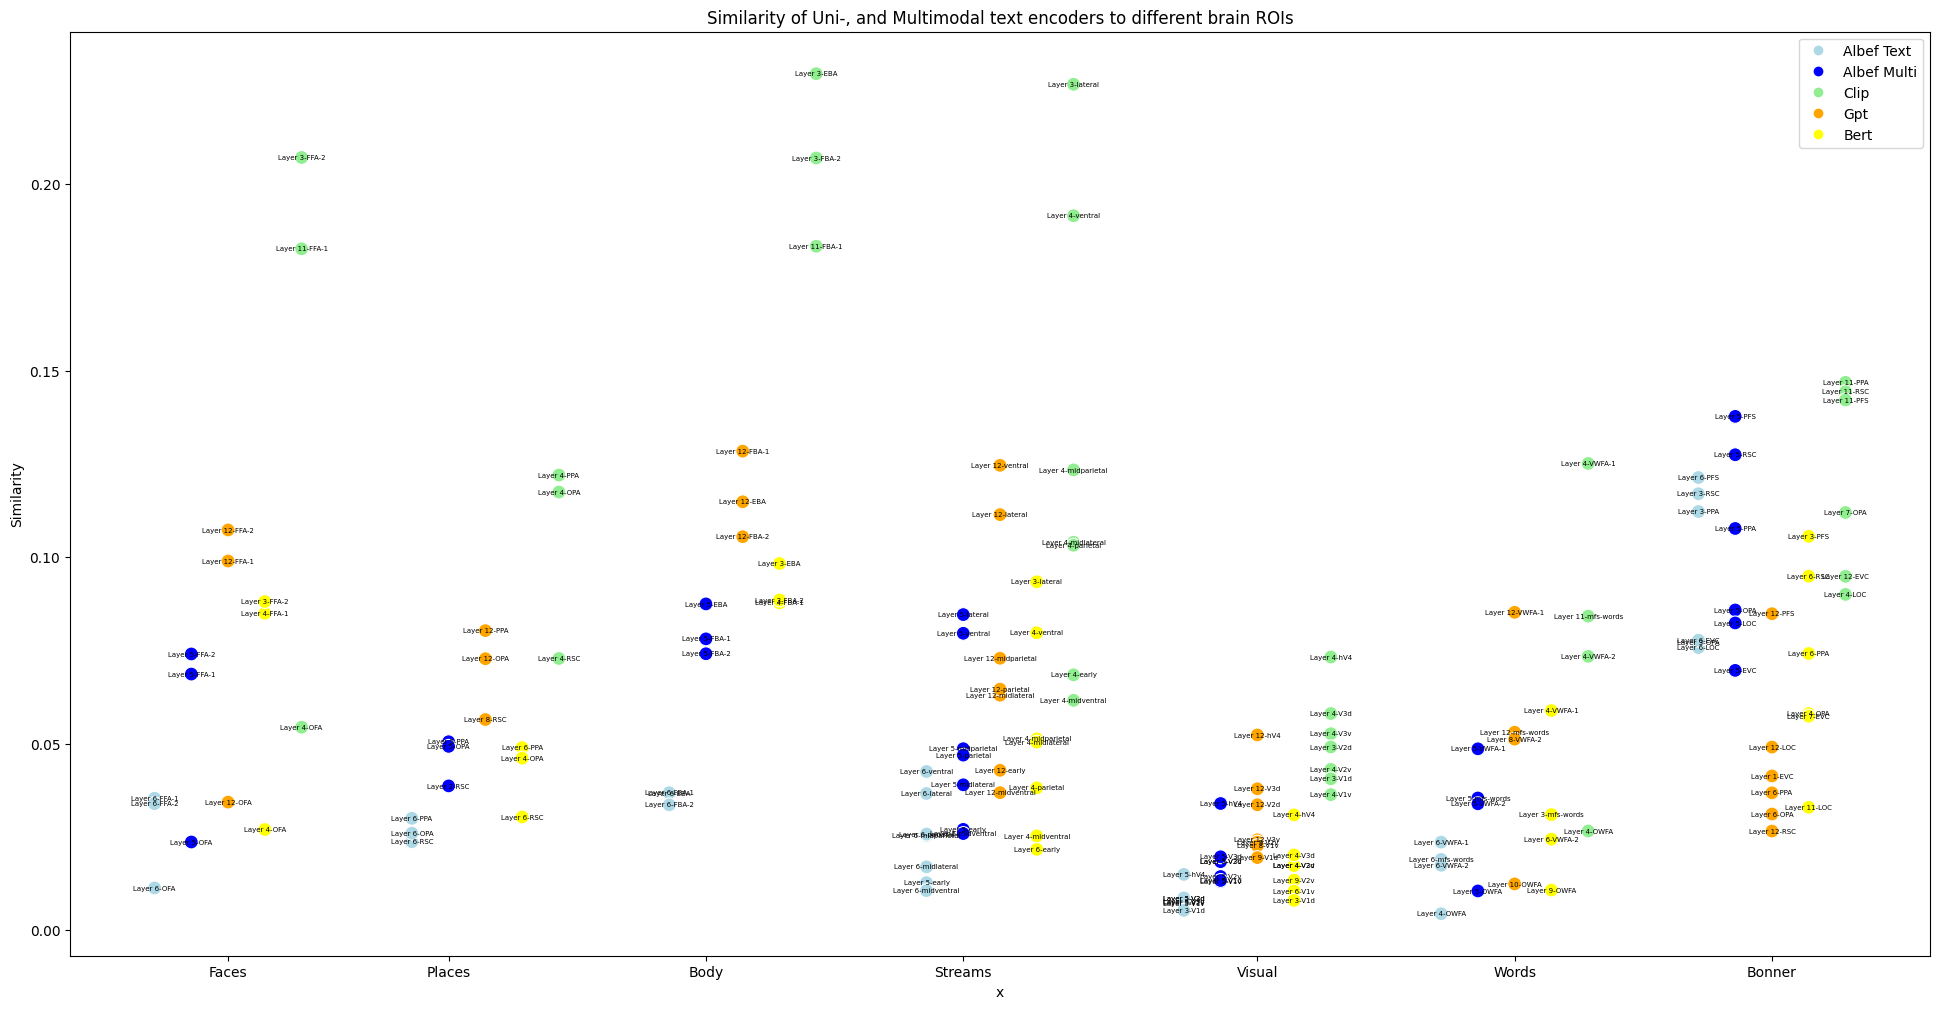

In [26]:
def plot_scatter_with_color_and_legend(data_sets):
    data_sets_names = list(data_sets.keys())
    labels = list(data_sets[data_sets_names[0]].keys())
    num_data_sets = len(data_sets)

    # Increase the figure size for larger individual scatter plots
    fig, ax = plt.subplots(figsize=(24, 12))

    # Color codes for the regions (you can change these to your desired colors)
    colors = {'Albef Text':'lightblue', 'Albef Multi':'blue', 'Clip':'lightgreen', 'Gpt': 'orange', 'Bert':'yellow'}

    # Create the scatterplot for each data set
    all_scatters = []
    i = 0
    z = 0
    for k, data_set in data_sets.items():
        l_x = []
        l_y = []
        l_label = []
        l_model = []
        df = pd.DataFrame(columns=['x', 'y', 'label', 'model_name'])
        values = [data_set[label][0][0] for label in labels]
        j = 1 + z
        for model_name in data_set.keys():
            old = [(item[0][0], item[0][1]) for item in data_set[model_name]]
            old_roi = [item[1] for item in data_set[model_name]]
            y = [item[1] for item in old]
            x = [j for i in range(len(y))]
            j += 1
            lab = [f"{item[0]}-{lab}" for item, lab in zip(old, old_roi)]
            model_n = [model_name for i in range(len(y))]
            l_x += x
            l_y += y
            l_label += lab
            l_model += model_n
        df['x'] = l_x
        df['y'] = l_y
        df['label'] = l_label
        df['model_name'] = l_model
        
        scatter = sns.scatterplot(x='x', y='y', data=df, hue='model_name', palette=colors, s=100, ax=ax, legend=False)
        
        for index, row in df.iterrows():
            ax.annotate(' '.join(row['label'].split(' ')[-2:]), (row['x'], row['y']), fontsize=5, ha='center', va='center')
        all_scatters.append(scatter)
        z += 7
        i += 1

    # Add labels to the x-axis
    ax.set_xticks([3, 9, 16, 23, 31, 38, 45])
    ax.set_xticklabels(data_sets_names)
    ax.set_ylabel('Similarity')

    # Create a legend for the colors and data sets
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
    plt.legend(markers, colors.keys(), numpoints=1)

    plt.title('Similarity of Uni-, and Multimodal text encoders to different brain ROIs')
    plt.show()
    
plot_scatter_with_color_and_legend(d_total)


In [32]:
import pickle
file_path = 'BestTextLayersAlgonauts2.pkl'

# Save the dictionary to the file using Pickle
with open(file_path, 'wb') as file:
    pickle.dump(permutation_dict, file)